# Imports

In [31]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

# Preparing Data

In [32]:
def make_pairs(images, labels):

    pairImages = []
    pairLabels = []
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    return (np.array(pairImages), np.array(pairLabels))

In [33]:
(x_train, y_train),(x_test, y_test)=mnist.load_data()

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

x_train=x_train / 255.0
x_test=x_test / 255.0

(pair_train, label_train) = make_pairs(x_train, y_train)
(pair_test, label_test) = make_pairs(x_test, y_test)

label_train=label_train.astype('float32')
label_test=label_test.astype('float32')

<class 'numpy.ndarray'>


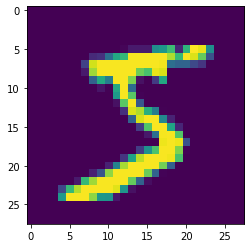

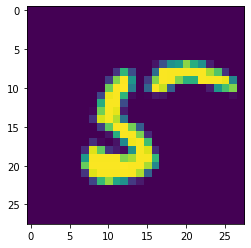

[1.]


In [34]:
print(type(x_train))
plt.figure()
plt.imshow(pair_train[0][0])
plt.figure()
plt.imshow(pair_train[0][1])
plt.show()
print(label_train[0])


# Model

In [35]:
def base_model():
    
    input=Input(shape=(28,28,))
    x=Flatten()(input)
    x=Dense(128, activation='relu')(x)
    x=Dropout(0.1)(x)
    x=Dense(128, activation='relu')(x)
    x=Dropout(0.1)(x)
    x=Dense(128, activation='relu')(x)
    
    model=Model(inputs=input, outputs=x)
    
    return model


In [36]:
def cal_eclidean_dist(vects):
    
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
    
    

In [37]:
base=base_model()
input_val_a=Input(shape=(28, 28,))
outpu_value_a=base(input_val_a)
input_val_b=Input(shape=(28,28,))
out_put_val_b=base(input_val_b)
output= Lambda(cal_eclidean_dist)([outpu_value_a, out_put_val_b])
model=Model(inputs=[input_val_a, input_val_b], outputs=output)


In [38]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):

        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [39]:
rms=RMSprop()
model.compile(optimizer=rms,
             loss=contrastive_loss_with_margin(margin=1)
             )

In [40]:
history = model.fit([pair_train[:,0], pair_train[:,1]], 
                    label_train, epochs=20, 
                    batch_size=128, 
                    validation_data=([pair_test[:,0], pair_test[:,1]],label_test)
                   )

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0920 - val_loss: 0.0449
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0397 - val_loss: 0.0327
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0283 - val_loss: 0.0287
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0227 - val_loss: 0.0274
Epoch 5/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0195 - val_loss: 0.0271
Epoch 6/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0176 - val_loss: 0.0248
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0154 - val_loss: 0.0247
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0241
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0132 - val_loss: 0.0251
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 0.0123 - val_loss: 0.0252

# Test Model

In [49]:
print(model.predict([pair_test[2, 0], pair_test[2, 1]]))
print(label_test[2])
print(model.predict([pair_test[101, 0], pair_test[101, 1]]))
print(label_test[7])

1/1 [==============================] - 0s 66ms/step
[[0.02791174]]
[1.]
1/1 [==============================] - 0s 15ms/step
[[0.98705125]]
[0.]


In [47]:
def cal_accuracy(y_true, y_pred):
    
    pred = np.ravel(y_pred) < 0.5
    int_pred=pred.astype(int)
    count=0
    for i in range(len(pred)):
        if int_pred[i] == y_true[i]:
            count += 1
        
    return count / len(pred)
    

In [48]:
pred_test=model.predict([pair_test[:, 0], pair_test[:, 1]])
accuracy=cal_accuracy(label_test, pred_test)
print(accuracy)
y_pred_train = model.predict([pair_train[:, 0], pair_train[:, 1]])
train_accuracy = cal_accuracy(label_train, y_pred_train)
print(train_accuracy)

625/625 [==============================] - 1s 1ms/step
0.9716
3750/3750 [==============================] - 4s 1ms/step
0.995525
